# Parallel Tempering with Multiple Chains

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Define target likelihood function

In [2]:
LAM = 12

def likelihood(x):
    """
    Likelihood of x

    Parameters
    ----------
    x : 1d-array or 2d-array
        Array containing the horizontal and vertical component of one or several
        vectors.

    Returns
    -------
    likelihood : float or 1d-array
        Likelihood of vector x.
    """
    # Convert the argument into 2d-array in order to make this function capable of
    # computing likelihoods for multiple vectors
    x = np.atleast_2d(x)
    x1 = x[:, 0]
    x2 = x[:, 1]
    return np.exp(-(x1 ** 2 + x2 ** 2 + (x1 * x2) ** 2) - 2 * LAM * x1 * x2 / 2)

## Define parameters

In [3]:
iterations = int(1e4)
temperatures = np.arange(1, 11)  # temperatures of the chains
probability_of_swap = 0.5  # the probability to attempt a swap
iterations_swap = 10  # attempt a swap after this number of iterations
sigma = temperatures / 5
starting_proposal = np.array([5, 5])  # proporsal to initialize the chains

In [4]:
print("Temperatures of the chains: {}".format(temperatures))

Temperatures of the chains: [ 1  2  3  4  5  6  7  8  9 10]


## Initialize arrays and chains

In [5]:
n_chains = len(temperatures)  # get number of chains from number of temps
x = np.zeros((n_chains, 2))  # define array for x vectors for each chain
probability = np.zeros(n_chains)  # probabilities for each chain
sampled_points = np.empty((n_chains, iterations, 2))  # array for sampled points

# Initialize chain
for chain in range(n_chains):
    # Proposal + gaussian noise
    x[chain, :] = starting_proposal + sigma[chain] * np.random.randn(2)
    # Compute probability of the x vector on each chain
    probability[chain] = likelihood(x[chain, :])

## Perform Parallel Tempering

In [6]:
for iteration in range(1, iterations):
    
    # Attempt swap every "iteration_swap" iterations
    if iteration % iterations_swap == 0:
        if probability_of_swap > np.random.rand():
            # Randomly choose two chains to attempt to swap
            i, j = np.random.choice(n_chains, 2)
            # Compute alpha between this pair of chains
            alpha = min(
                1,
                (probability[j] / probability[i]) ** (1 / temperatures[i])
                * (probability[i] / probability[j]) ** (1 / temperatures[j]),
            )
            # Decide if we should swap chains i and j
            if alpha > np.random.rand():
                x[i, :], x[j, :] = x[j, :], x[i, :]
                probability[i], probability[j] = probability[j], probability[i]

    # Perform MCMC
    for chain in range(n_chains):
        x_trial = x[chain, :] + sigma[chain] * np.random.randn(2)
        probability_trial = likelihood(x_trial)
        acceptance = min(
            1, (probability_trial / probability[chain]) ** (1 / temperatures[chain])
        )
        if acceptance > np.random.rand():
            x[chain, :] = x_trial
            probability[chain] = probability_trial
        # Add sampled points to array
        sampled_points[chain, iteration, :] = x[chain, :]

/home/santi/.anaconda3/envs/lapis2019/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/home/santi/.anaconda3/envs/lapis2019/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in true_divide
/home/santi/.anaconda3/envs/lapis2019/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/home/santi/.anaconda3/envs/lapis2019/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':
/home/santi/.anaconda3/envs/lapis2019/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


## Plot results

In [7]:
# Compute target PDF for contour plots
x1 = np.linspace(-4, 4, 101)
x1, x2 = np.meshgrid(x1, x1)
target = likelihood(np.hstack((x1[:, np.newaxis], x2[:, np.newaxis])))
target = target.reshape(x1.shape)

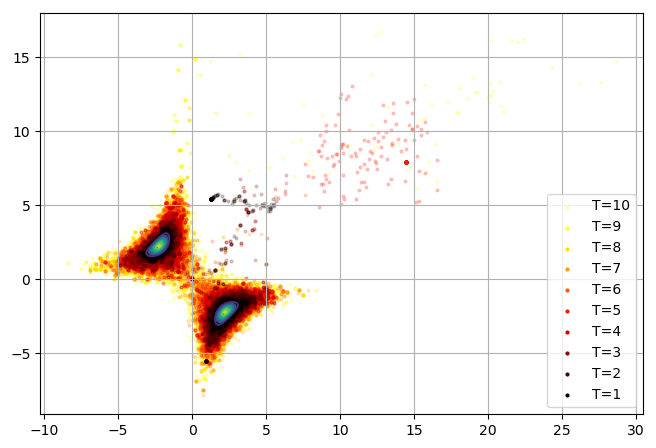

In [8]:
# Define colors for every chain
colors = dict(zip(range(n_chains), plt.cm.hot(np.linspace(0, 0.9, n_chains))))

fig, ax = plt.subplots(figsize=(6.66, 6.66), dpi=100)

ax.contour(x1, x2, target)
for chain in range(n_chains)[::-1]:
    ax.scatter(
        sampled_points[chain, :, 0],
        sampled_points[chain, :, 1],
        s=4,
        alpha=0.2,
        color=colors[chain],
        label="T={}".format(temperatures[chain]),
    )
ax.set_aspect("equal")
ax.grid()
legend = ax.legend()
for symbol in legend.legendHandles:
    symbol.set_alpha(1)  # make legend symbol non-transparent
fig.tight_layout()
plt.show()